
# 🏀 NBA Shot Prediction — End‑to‑End Project (A → Z)

**Dataset:** mexwell / nba-shots (place CSVs locally)  
**Local path expected:** `ShotPrediction/ShotData/` (folder with many `NBA_YYYY_Shots.csv` files)

This notebook walks through a complete **shot‑make probability** pipeline:
1. Load + merge multi‑season data
2. Clean and explore (EDA) with visuals
3. Guard against *target leakage* and craft features
4. Build train/validation split and ML pipelines
5. Train baseline (Logistic Regression) and tree model (Random Forest)
6. Evaluate with accuracy, ROC‑AUC, PR‑AUC, confusion matrix
7. Inspect feature effects (coefficients / importances)
8. Make a simple spatial shot‑probability map
9. Save model(s) and demonstrate inference

> **Tip:** The raw dataset is large (millions of rows). For quick iteration, you can start in **FAST_MODE**
> (sample a subset), then switch to the full dataset later.


In [1]:

# === Imports & Setup ===
import os, glob, math, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import joblib

warnings.filterwarnings("ignore")

# === Config ===
# Change this if your data is elsewhere:
DATA_DIR = "ShotData"

RANDOM_STATE = 42
FAST_MODE = True   # set to False to load the entire dataset
FAST_NROWS = 120_000  # total rows (after concatenation) when FAST_MODE is True

pd.set_option('display.max_columns', 120)
print("Using DATA_DIR:", DATA_DIR)


Using DATA_DIR: ShotData



## 1) Load & Merge the Multi‑Season Dataset

The Kaggle dataset provides one CSV per season. We will:
- Glob all files in `ShotData`
- Read and **concatenate** them into one DataFrame
- Optionally sample in **FAST_MODE** for speed

**Columns overview (from the dataset):**
- `SEASON_1`/`SEASON_2`: season start/end years (e.g., 2023/2024)
- `TEAM_ID`, `TEAM_NAME`
- `PLAYER_ID`, `PLAYER_NAME`, `POSITION_GROUP`, `POSITION`
- `GAME_DATE`, `GAME_ID`, `HOME_TEAM`, `AWAY_TEAM`
- `EVENT_TYPE` *(e.g., 'Made Shot' / 'Missed Shot' — **leaks the target**, we will drop it)*
- `SHOT_MADE` *(boolean True/False — **our target**)*
- `ACTION_TYPE`, `SHOT_TYPE` (2PT vs 3PT)
- `BASIC_ZONE`, `ZONE_NAME`, `ZONE_ABB`, `ZONE_RANGE`
- `LOC_X`, `LOC_Y` *(court x/y coordinates)*
- `SHOT_DISTANCE` *(in feet)*
- `QUARTER`, `MINS_LEFT`, `SECS_LEFT`


In [2]:

# Load and merge
files = sorted(glob.glob(os.path.join(DATA_DIR, "NBA_*_Shots.csv")))

dfs = []
total_rows = 0
for f in files:
    if FAST_MODE:
        chunk = pd.read_csv(f, nrows=FAST_NROWS // max(1, len(files)))
    else:
        chunk = pd.read_csv(f)
    dfs.append(chunk)
    total_rows += len(chunk)

df = pd.concat(dfs, ignore_index=True)
print("Files loaded:", len(files), "Total rows:", len(df))
df.head(3)


Files loaded: 21 Total rows: 119994


,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9



## 2) Basic Quality Checks & Missingness

We check for:
- Basic info, missing values
- Target distribution
- Duplicates (and remove if any)


In [3]:

# Info and NA counts
display(df.info())
na_counts = df.isna().sum().sort_values(ascending=False)
print("Top missing counts:\n", na_counts.head(10))

# Drop exact duplicates, if any
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before - after} duplicate rows.")

# Target distribution
if "SHOT_MADE" not in df.columns:
    raise KeyError("Expected column 'SHOT_MADE' not found. Please verify the dataset version.")
print("Target distribution (SHOT_MADE):\n", df["SHOT_MADE"].value_counts(normalize=True))

# Convert SHOT_MADE to int for modeling
df["SHOT_MADE"] = df["SHOT_MADE"].astype(int)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119994 entries, 0 to 119993
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        119994 non-null  int64  
 1   SEASON_2        119994 non-null  object 
 2   TEAM_ID         119994 non-null  int64  
 3   TEAM_NAME       119994 non-null  object 
 4   PLAYER_ID       119994 non-null  int64  
 5   PLAYER_NAME     119994 non-null  object 
 6   POSITION_GROUP  119747 non-null  object 
 7   POSITION        119747 non-null  object 
 8   GAME_DATE       119994 non-null  object 
 9   GAME_ID         119994 non-null  int64  
 10  HOME_TEAM       119994 non-null  object 
 11  AWAY_TEAM       119994 non-null  object 
 12  EVENT_TYPE      119994 non-null  object 
 13  SHOT_MADE       119994 non-null  bool   
 14  ACTION_TYPE     119994 non-null  object 
 15  SHOT_TYPE       119994 non-null  object 
 16  BASIC_ZONE      119994 non-null  object 
 17  ZONE_NAME 

None

Top missing counts:
 POSITION_GROUP    247
POSITION          247
SEASON_1            0
ACTION_TYPE         0
MINS_LEFT           0
QUARTER             0
SHOT_DISTANCE       0
LOC_Y               0
LOC_X               0
ZONE_RANGE          0
dtype: int64
Dropped 1 duplicate rows.
Target distribution (SHOT_MADE):
 SHOT_MADE
False    0.53904
True     0.46096
Name: proportion, dtype: float64



## 3) Exploratory Data Analysis (EDA)

We’ll visualize simple but decision‑making plots with **matplotlib only**:
- **Shot distance** distribution
- **Make rate vs distance** (binned)
- **Make rate by zone**
- **A quick shot chart** (scatter sample on the court coordinates)


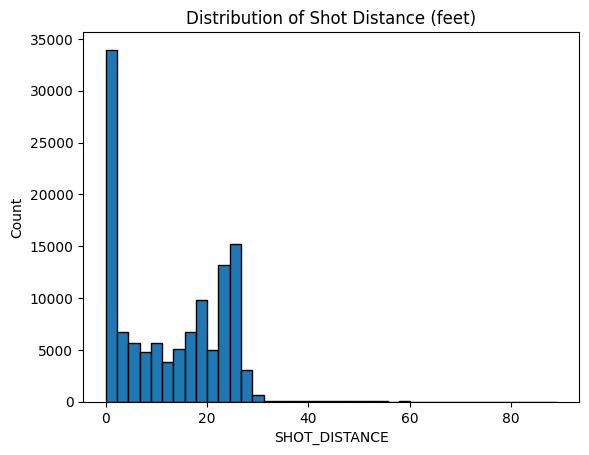

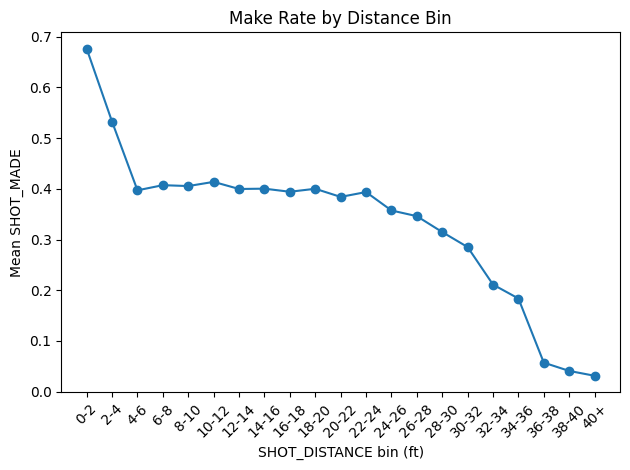

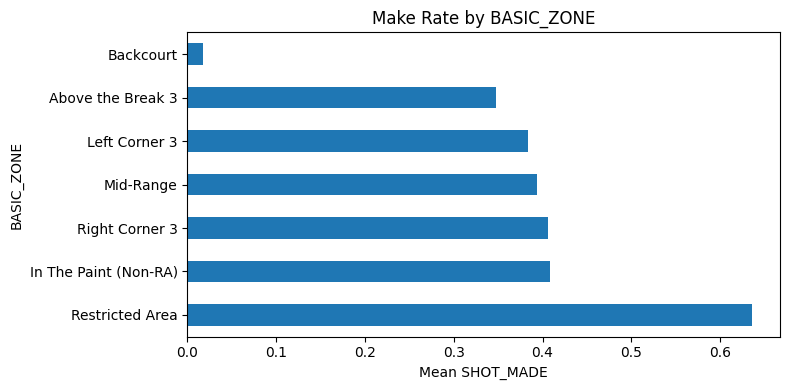

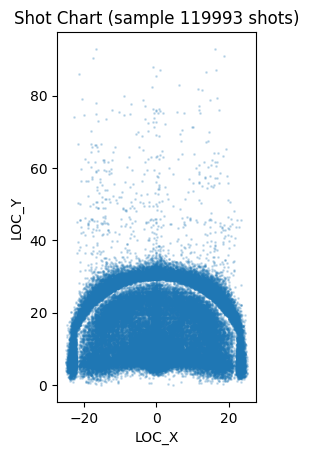

In [4]:

# Histogram of shot distances
plt.figure()
df["SHOT_DISTANCE"].plot(kind="hist", bins=40, edgecolor="black")
plt.title("Distribution of Shot Distance (feet)")
plt.xlabel("SHOT_DISTANCE")
plt.ylabel("Count")
plt.show()

# Make rate vs binned distance
bins = list(range(0, 41, 2)) + [100]

# Build labels to match exactly len(bins)-1
labels = [
    (f"{bins[i]}-{bins[i+1]}" if bins[i+1] < 100 else f"{bins[i]}+")
    for i in range(len(bins)-1)]
dist_bin = pd.cut(df["SHOT_DISTANCE"], bins=bins, labels=labels, include_lowest=True, right=False)
make_rate_by_dist = df.groupby(dist_bin)["SHOT_MADE"].mean().reset_index()

plt.figure()
plt.plot(make_rate_by_dist["SHOT_DISTANCE"].astype(str), make_rate_by_dist["SHOT_MADE"], marker="o")
plt.title("Make Rate by Distance Bin")
plt.xlabel("SHOT_DISTANCE bin (ft)")
plt.ylabel("Mean SHOT_MADE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Make rate by BASIC_ZONE
if "BASIC_ZONE" in df.columns:
    by_zone = df.groupby("BASIC_ZONE")["SHOT_MADE"].mean().sort_values(ascending=False)
    plt.figure(figsize=(8, max(4, 0.3*len(by_zone))))
    by_zone.plot(kind="barh")
    plt.title("Make Rate by BASIC_ZONE")
    plt.xlabel("Mean SHOT_MADE")
    plt.ylabel("BASIC_ZONE")
    plt.tight_layout()
    plt.show()

# Quick shot chart (scatter)
# Sample to avoid huge overplotting
sample_n = min(120_000, len(df))
shot_sample = df.sample(sample_n, random_state=RANDOM_STATE)

xcol = "LOC_X" if "LOC_X" in shot_sample.columns else ("LOC_x" if "LOC_x" in shot_sample.columns else None)
ycol = "LOC_Y" if "LOC_Y" in shot_sample.columns else ("LOC_y" if "LOC_y" in shot_sample.columns else None)

if xcol and ycol:
    plt.figure()
    plt.scatter(shot_sample[xcol], shot_sample[ycol], s=1, alpha=0.2)
    plt.title(f"Shot Chart (sample {sample_n} shots)")
    plt.xlabel("LOC_X")
    plt.ylabel("LOC_Y")
    plt.gca().set_aspect('equal', 'box')
    plt.show()
else:
    print("LOC_X/LOC_Y not found for plotting.")



### Why these plots & what they tell us

- **Distance matters**: Make rates decrease as the shot is farther from the rim.  
  Modeling should include `SHOT_DISTANCE` and/or raw coordinates `LOC_X`, `LOC_Y`.

- **Zones matter**: Areas like **restricted area** or **paint** historically have higher FG%.  
  Use `BASIC_ZONE` / `ZONE_RANGE` / `SHOT_TYPE` (2PT vs 3PT) as predictive features.

- **Raw coordinates capture geometry**: Using `LOC_X`, `LOC_Y` lets models learn subtle hot/cold areas beyond coarse zones.

- **Avoid leakage**: `EVENT_TYPE` literally encodes *Made* vs *Missed* and must be dropped.



## 4) Feature Engineering

We construct:
- `SECS_REMAINING = MINS_LEFT*60 + SECS_LEFT` (game context)
- `IS_HOME = 1 if TEAM_NAME == HOME_TEAM else 0`
- `ABS_X`, `ABS_Y`, `ANGLE` (simple geometric features)
- `CLUTCH = 1 if SECS_REMAINING ≤ 120 else 0`
- Keep categorical basketball semantics: `SHOT_TYPE`, `BASIC_ZONE`, `ZONE_RANGE`, `POSITION_GROUP`

We also **drop** obvious IDs and leakage fields:
`EVENT_TYPE`, `GAME_ID`, `GAME_DATE`, `PLAYER_ID`, `PLAYER_NAME`, `TEAM_ID`.


In [11]:

# === Feature Engineering ===
df["SECS_REMAINING"] = df["MINS_LEFT"] * 60 + df["SECS_LEFT"]
df["IS_HOME"] = (df["TEAM_NAME"] == df["HOME_TEAM"]).astype(int)

# Geometry: absolute coordinates & angle (basket assumed around (0,0) in this dataset)
df["ABS_X"] = df["LOC_X"].abs()
df["ABS_Y"] = df["LOC_Y"].abs()
# Angle wrt vertical axis; guard against /0 by adding small epsilon to Y
df["ANGLE_DEG"] = np.degrees(np.arctan2(df["ABS_X"], (df["ABS_Y"] + 1e-6)))
df["CLUTCH"] = (df["SECS_REMAINING"] <= 120).astype(int)

# Columns to drop for modeling (IDs/leakage/high‑card labels we won’t use directly)
drop_cols = [
    "EVENT_TYPE",   # leaks target
    "GAME_ID", "GAME_DATE",
    "PLAYER_ID", "PLAYER_NAME",
    "TEAM_ID",
    # we’ll keep TEAM_NAME only to create IS_HOME above; can drop afterward:
    "HOME_TEAM", "AWAY_TEAM", "TEAM_NAME"
]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Select target and features
y = df_model["SHOT_MADE"].astype(int)
X = df_model.drop(columns=["SHOT_MADE"])

df["SEASON_2_NUM"] = df["SEASON_2"].str[:4].astype(int)

# Split numerical/categorical
numeric_cols = [
    c for c in ["LOC_X","LOC_Y","SHOT_DISTANCE","QUARTER",
                "MINS_LEFT","SECS_LEFT","SECS_REMAINING",
                "ABS_X","ABS_Y","ANGLE_DEG","CLUTCH","IS_HOME",
                "SEASON_1","SEASON_2_NUM"]
    if c in X.columns
]

categorical_cols = [
    c for c in ["ACTION_TYPE","SHOT_TYPE","BASIC_ZONE","ZONE_NAME",
                "ZONE_ABB","ZONE_RANGE","POSITION_GROUP","POSITION"]
    if c in X.columns
]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("X shape:", X.shape)


Numeric cols: ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'SECS_REMAINING', 'ABS_X', 'ABS_Y', 'ANGLE_DEG', 'CLUTCH', 'IS_HOME', 'SEASON_1']
Categorical cols: ['ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
X shape: (119993, 22)



## 5) Train/Validation Split & ML Pipelines

We’ll use a **scikit‑learn `ColumnTransformer` + `Pipeline`** to:
- Impute missing values
- Scale numeric features
- One‑hot encode categoricals (with unknowns ignored)
- Fit **Logistic Regression** (baseline) and **Random Forest** (nonlinear)


In [12]:

# Train/Validation split (use stratify to preserve class balance)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Preprocess
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # with_mean=False is safer if sparse matrices end up here
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

# Baseline: Logistic Regression
logreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500, solver="saga", n_jobs=1, random_state=RANDOM_STATE))
])

# Nonlinear: Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_split=4, n_jobs=-1, random_state=RANDOM_STATE
    ))
])

print("Pipelines ready.")


Pipelines ready.


In [13]:

def evaluate_model(pipe, X_tr, y_tr, X_te, y_te, name="Model"):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    y_prob = pipe.predict_proba(X_te)[:, 1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan

    # PR-AUC
    if y_prob is not None:
        prec, rec, thr = precision_recall_curve(y_te, y_prob)
        pr_auc = auc(rec, prec)
    else:
        pr_auc = np.nan

    print(f"{name} — Accuracy: {acc:.3f} | ROC-AUC: {roc:.3f} | PR-AUC: {pr_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} — Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Miss", "Make"])
    plt.yticks(tick_marks, ["Miss", "Make"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # ROC Curve (if probs available)
    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_te, y_prob, name=name)
        plt.title(f"{name} — ROC Curve")
        plt.show()

    return {"acc": acc, "roc_auc": roc, "pr_auc": pr_auc}



## 6) Train & Evaluate Models


Logistic Regression — Accuracy: 0.635 | ROC-AUC: 0.664 | PR-AUC: 0.664


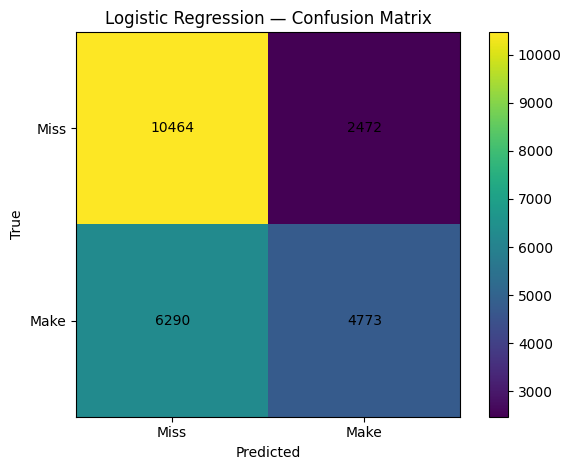

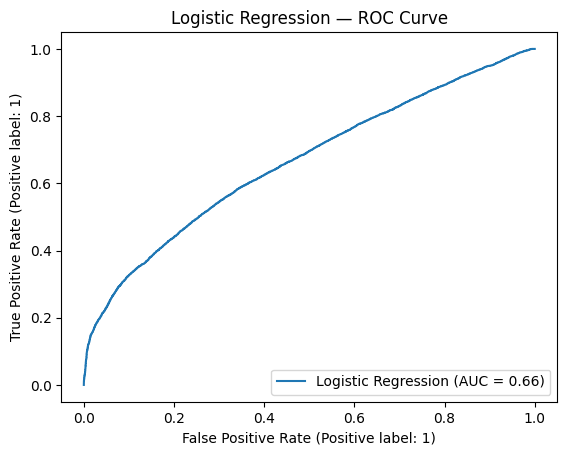

Random Forest — Accuracy: 0.627 | ROC-AUC: 0.654 | PR-AUC: 0.656


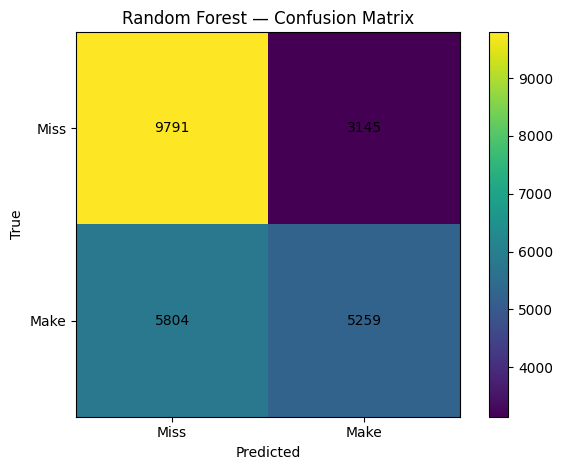

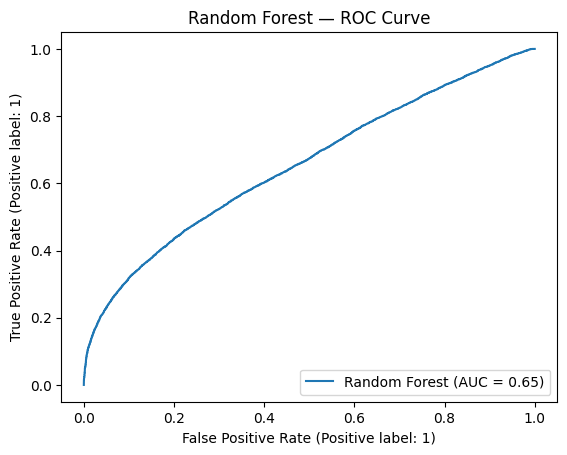

Summary: {'logreg': {'acc': 0.6349014542272595, 'roc_auc': 0.6643710075387094, 'pr_auc': 0.664107766287992}, 'rf': {'acc': 0.6271094628942873, 'roc_auc': 0.6544255294255295, 'pr_auc': 0.6563141551371171}}


In [14]:

metrics_logreg = evaluate_model(logreg, X_train, y_train, X_valid, y_valid, name="Logistic Regression")
metrics_rf     = evaluate_model(rf,     X_train, y_train, X_valid, y_valid, name="Random Forest")
print("Summary:", {"logreg": metrics_logreg, "rf": metrics_rf})



## 7) What drives predictions? (Feature Effects)

- For **Logistic Regression**, we can inspect top positive/negative **coefficients**.
- For **Random Forest**, we can inspect **feature importances**.


In [15]:

# Helper to extract feature names after preprocessing (num + cat)
def get_feature_names(preprocess: ColumnTransformer):
    # Numeric names come from the provided list
    output_features = list(numeric_cols)
    # Categorical names from OneHotEncoder
    for name, trans, cols in preprocess.transformers_:
        if name == "cat":
            ohe = trans.named_steps["onehot"]
            cat_names = ohe.get_feature_names_out(cols)
            output_features += list(cat_names)
    return output_features

# Fit a small clone on training data so we can extract names/coefficients
logreg.fit(X_train, y_train)

# Get feature names
feature_names = get_feature_names(logreg.named_steps["preprocess"])

# Logistic coefficients
clf_lr = logreg.named_steps["clf"]
coefs = clf_lr.coef_[0]
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

top_pos = coef_df.head(15)
top_neg = coef_df.tail(15).sort_values("coef")

print("Top + coefficients (increase make probability):")
display(top_pos)

print("Top - coefficients (decrease make probability):")
display(top_neg)


Top + coefficients (increase make probability):


,feature,coef
68,ACTION_TYPE_Slam Dunk Shot,0.920213
15,ACTION_TYPE_Cutting Dunk Shot,0.783939
31,ACTION_TYPE_Dunk Shot,0.773940
57,ACTION_TYPE_Running Dunk Shot,0.653850
20,ACTION_TYPE_Driving Dunk Shot,0.552089
13,ACTION_TYPE_Alley Oop Dunk Shot,0.518957
88,BASIC_ZONE_Restricted Area,0.396134
47,ACTION_TYPE_Putback Dunk Shot,0.353346
102,ZONE_RANGE_16-24 ft.,0.344777
41,ACTION_TYPE_Jump Bank Shot,0.285957


Top - coefficients (decrease make probability):


,feature,coef
44,ACTION_TYPE_Layup Shot,-1.073463
73,ACTION_TYPE_Tip Shot,-1.056839
43,ACTION_TYPE_Jump Shot,-0.808710
72,ACTION_TYPE_Tip Layup Shot,-0.766321
2,SHOT_DISTANCE,-0.506689
27,ACTION_TYPE_Driving Layup Shot,-0.457105
70,ACTION_TYPE_Step Back Jump shot,-0.426991
106,ZONE_RANGE_Less Than 8 ft.,-0.400374
85,BASIC_ZONE_In The Paint (Non-RA),-0.368824
39,ACTION_TYPE_Hook Shot,-0.358837


,feature,importance
6,SECS_REMAINING,0.101070
5,SECS_LEFT,0.094932
9,ANGLE_DEG,0.083887
1,LOC_Y,0.076398
8,ABS_Y,0.075944
0,LOC_X,0.073010
12,SEASON_1,0.072199
7,ABS_X,0.071640
4,MINS_LEFT,0.055175
2,SHOT_DISTANCE,0.048209


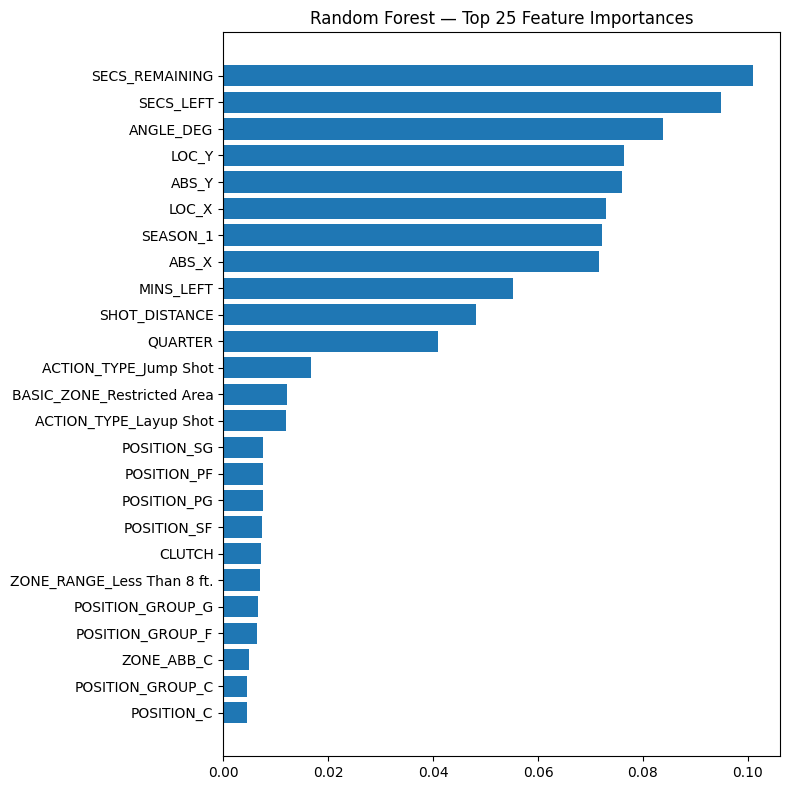

In [16]:

# Random Forest feature importances
rf.fit(X_train, y_train)
feature_names = get_feature_names(rf.named_steps["preprocess"])
importances = rf.named_steps["clf"].feature_importances_

imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(25)
display(imp_df)

plt.figure(figsize=(8, 8))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.title("Random Forest — Top 25 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## 8) Spatial Shot‑Make Probability Map (2D bins)

We map the court (`LOC_X`, `LOC_Y`) into bins and compute the **empirical make rate** in each bin.
This gives a simple heatmap style view (not a full hexbin) of hot/cold areas.


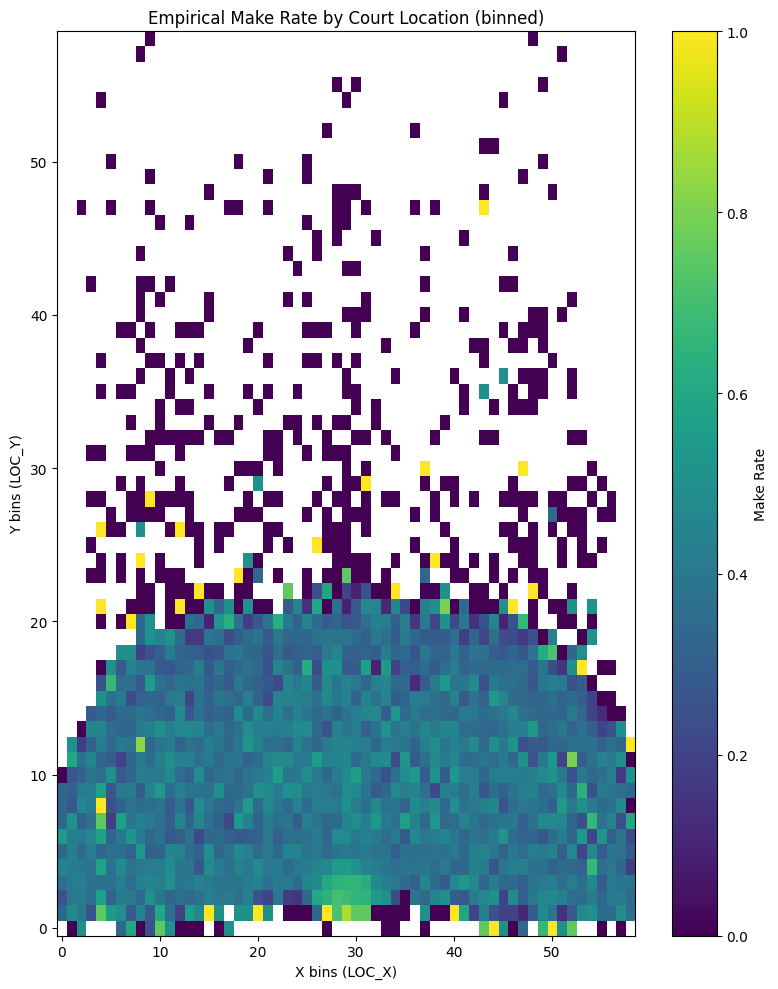

In [17]:

# Use a sample to keep it fast in very large datasets
grid_sample = df.sample(min(600_000, len(df)), random_state=RANDOM_STATE)

# Define bin edges (dataset LOC ranges are typically within ~[-250, 250] for X and ~[-50, 900] for Y)
x_bins = np.linspace(grid_sample["LOC_X"].min(), grid_sample["LOC_X"].max(), 60)
y_bins = np.linspace(grid_sample["LOC_Y"].min(), grid_sample["LOC_Y"].max(), 60)

x_idx = np.digitize(grid_sample["LOC_X"], x_bins) - 1
y_idx = np.digitize(grid_sample["LOC_Y"], y_bins) - 1

# Clamp indices to valid range
x_idx = np.clip(x_idx, 0, len(x_bins)-2)
y_idx = np.clip(y_idx, 0, len(y_bins)-2)

# Aggregate make rate per cell
heat = np.zeros((len(y_bins)-1, len(x_bins)-1), dtype=float)
count = np.zeros_like(heat, dtype=int)

for xi, yi, made in zip(x_idx, y_idx, grid_sample["SHOT_MADE"]):
    heat[yi, xi] += made
    count[yi, xi] += 1

with np.errstate(divide='ignore', invalid='ignore'):
    rate = np.where(count > 0, heat / count, np.nan)

plt.figure(figsize=(8, 10))
plt.imshow(rate, origin="lower", aspect="auto")
plt.title("Empirical Make Rate by Court Location (binned)")
plt.xlabel("X bins (LOC_X)")
plt.ylabel("Y bins (LOC_Y)")
plt.colorbar(label="Make Rate")
plt.tight_layout()
plt.show()



## 9) Save Trained Models & Quick Inference

We persist both models with `joblib` and run an example inference on a single row.


In [18]:

os.makedirs("models", exist_ok=True)
joblib.dump(logreg, "models/logreg_shot.pkl")
joblib.dump(rf, "models/rf_shot.pkl")
print("Saved models to ./models/")

# Example inference on a random sample
one = X_valid.sample(1, random_state=RANDOM_STATE)
true_label = y_valid.loc[one.index].iloc[0]

prob_lr = float(logreg.predict_proba(one)[:,1])
prob_rf = float(rf.predict_proba(one)[:,1])
pred_lr = int(prob_lr >= 0.5)
pred_rf = int(prob_rf >= 0.5)

print("True label:", true_label)
print("LogReg prob:", round(prob_lr, 3), "pred:", pred_lr)
print("RandForest prob:", round(prob_rf, 3), "pred:", pred_rf)


Saved models to ./models/
True label: 1
LogReg prob: 0.493 pred: 0
RandForest prob: 0.639 pred: 1



## 10) Notes, Choices & Pitfalls

- **No target leakage:** Dropped `EVENT_TYPE` because it encodes the same information as `SHOT_MADE`.
- **Features chosen:**
  - **Geometry:** `LOC_X`, `LOC_Y`, `SHOT_DISTANCE`, `ANGLE_DEG`.
  - **Context:** `SECS_REMAINING`, `CLUTCH`, `QUARTER`, `IS_HOME`.
  - **Semantics:** `SHOT_TYPE` (2PT/3PT), `BASIC_ZONE`, `ZONE_RANGE`, `ACTION_TYPE`, `POSITION_GROUP`.
- **What we didn’t include (yet):**
  - Player‑level historical accuracy (**target encoding** done within CV) — avoid leakage.
  - Opponent defense context, game score margin, fatigue, etc. (Not present here.)
- **Class balance:** Made vs missed is moderately balanced (~55/45). Standard metrics (accuracy, ROC‑AUC) are meaningful.
- **Evaluation:** A robust approach would use **time‑based splits** (train on older seasons, validate on newer) to test generalization across eras.
